In [22]:
!pip install transformers wikipedia neo4j kuzu langchain > /dev/null

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [23]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import math
import torch
import wikipedia
import IPython
import pandas as pd

# Load the REBEL model

In [24]:
# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

In [25]:
test_text = "The stock price of Tesla skyrocketed after the quarterly earnings report."

In [26]:
# Tokenizer text example
model_inputs = tokenizer(test_text,
                          max_length=512,
                          padding=True,
                          truncation=True,
                        return_tensors='pt')

print(f"Num tokens: {len(model_inputs['input_ids'][0])}")

# Generate
gen_kwargs = {
    "max_length": 216,
    "length_penalty": 0,
    "num_beams": 5,
    "num_return_sequences": 4
}
generated_tokens = model.generate(
    **model_inputs,
    **gen_kwargs,
)
decoded_preds = tokenizer.batch_decode(generated_tokens,
                                        skip_special_tokens=False)

decoded_preds

Num tokens: 15


['<s><triplet> quarterly earnings report <subj> Tesla <obj> main subject</s>',
 '<s><triplet> quarterly earnings report <subj> Tesla <obj> publisher</s><pad>',
 '<s><triplet> quarterly earnings report <subj> Tesla <obj> facet of</s>',
 '<s><triplet> quarterly earnings report <subj> Tesla <obj> named after</s>']

In [27]:
def extract_relations_from_model_output(text):
    relations = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    text_replaced = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
    for token in text_replaced.split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        relations.append({
            'head': subject.strip(),
            'type': relation.strip(),
            'tail': object_.strip()
        })
    return relations

### Defining class for smaller text inputs (processes entire text all at once)

In [28]:
class KB():
    def __init__(self):
        self.relations = []

    def are_relations_equal(self, r1, r2):
        return all(r1[attr] == r2[attr] for attr in ["head", "type", "tail"])

    def exists_relation(self, r1):
        return any(self.are_relations_equal(r1, r2) for r2 in self.relations)

    def add_relation(self, r):
        if not self.exists_relation(r):
            self.relations.append(r)

    def print(self):
        print("Relations:")
        for r in self.relations:
            print(f"  {r}")
            
    def save_csv(self,file_name):
        print(f"Saving to file {file_name}")
        reln_df = pd.DataFrame(self.relations)
        reln_df.to_csv(file_name,index=False)        
                

In [29]:
#In from_small_text_to_kb, the entire input text is tokenized and processed at once.
def from_small_text_to_kb(text, verbose=False):
    kb = KB()

    # Tokenizer text
    model_inputs = tokenizer(text,
                             max_length=512,
                             padding=True,
                             truncation=True,
                            return_tensors='pt')
    if verbose:
        print(f"Num tokens: {len(model_inputs['input_ids'][0])}")

    # Generate
    gen_kwargs = {
        "max_length": 216,
        "length_penalty": 0,
        "num_beams": 3,
        "num_return_sequences": 3
    }
    generated_tokens = model.generate(
        **model_inputs,
        **gen_kwargs,
    )
    decoded_preds = tokenizer.batch_decode(generated_tokens,
                                           skip_special_tokens=False)

    # create kb
    for sentence_pred in decoded_preds:
        relations = extract_relations_from_model_output(sentence_pred)
        for r in relations:
            kb.add_relation(r)

    return kb

In [30]:
#Example use 
small_kb = from_small_text_to_kb(test_text)

In [31]:
small_kb.print()

Relations:
  {'head': 'quarterly earnings report', 'type': 'main subject', 'tail': 'Tesla'}
  {'head': 'quarterly earnings report', 'type': 'publisher', 'tail': 'Tesla'}
  {'head': 'quarterly earnings report', 'type': 'facet of', 'tail': 'Tesla'}


### Split spans: from long text to KB (divides larger text into spans of 50 and processes each span separately)

In [32]:
class SpankB():
    def __init__(self):
        self.relations = []

    def are_relations_equal(self, r1, r2):
        return all(r1[attr] == r2[attr] for attr in ["head",
                                                     "type",
                                                     "tail"])

    def exists_relation(self, r1):
        return any(self.are_relations_equal(r1, r2) for r2 in self.relations)

    def merge_relations(self, r1):
        r2 = [r for r in self.relations
              if self.are_relations_equal(r1, r)][0]
        spans_to_add = [span for span in r1["meta"]["spans"]
                        if span not in r2["meta"]["spans"]]
        r2["meta"]["spans"] += spans_to_add

    def add_relation(self, r):
        if not self.exists_relation(r):
            self.relations.append(r)
        else:
            self.merge_relations(r)

    def print(self):
        print("Relations:")
        for r in self.relations:
            print(f"  {r}")

    def save_csv(self,file_name):
        print(f"Saving to file {file_name}")
        reln_df = pd.DataFrame(self.relations)
        reln_df.to_csv(file_name,index=False)

In [33]:
#In from_text_to_kb, the input text is divided into spans, and each span is tokenized and processed separately.

def from_text_to_kb(text,
                    span_length=50,
                    verbose=False):
    # tokenize whole text
    inputs = tokenizer([text], return_tensors="pt")

    # compute span boundaries
    num_tokens = len(inputs["input_ids"][0])
    if verbose:
        print(f"Input has {num_tokens} tokens")
    num_spans = math.ceil(num_tokens / span_length)
    if verbose:
        print(f"Input has {num_spans} spans")
    overlap = math.ceil((num_spans * span_length - num_tokens) /
                        max(num_spans - 1, 1))
    spans_boundaries = []
    start = 0
    for i in range(num_spans):
        spans_boundaries.append([start + span_length * i,
                                 start + span_length * (i + 1)])
        start -= overlap
    if verbose:
        print(f"Span boundaries are {spans_boundaries}")

    # transform input with spans
    tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]]
                  for boundary in spans_boundaries]
    tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]]
                    for boundary in spans_boundaries]
    inputs = {
        "input_ids": torch.stack(tensor_ids),
        "attention_mask": torch.stack(tensor_masks)
    }

    # generate relations
    num_return_sequences = 3
    gen_kwargs = {
        "max_length": 256,
        "length_penalty": 0,
        "num_beams": 3,
        "num_return_sequences": num_return_sequences
    }
    generated_tokens = model.generate(
        **inputs,
        **gen_kwargs,
    )

    # decode relations
    decoded_preds = tokenizer.batch_decode(generated_tokens,
                                           skip_special_tokens=False)

    # create kb
    kb = SpankB()
    i = 0
    for sentence_pred in decoded_preds:
        current_span_index = i // num_return_sequences
        relations = extract_relations_from_model_output(sentence_pred)
        for relation in relations:
            relation["meta"] = {
                "spans": [spans_boundaries[current_span_index]]
            }
            kb.add_relation(relation)
        i += 1

    return kb

In [34]:
#Example use of span class
#test_text2 of 100 words
test_text2= "Artificial intelligence (AI) has rapidly transformed various industries, from healthcare to finance. By leveraging advanced algorithms and vast amounts of data, AI systems can perform tasks that traditionally required human intelligence, such as diagnosing diseases, predicting stock market trends, and enhancing customer service. Despite its many benefits, the rise of AI also brings significant challenges, including ethical concerns about privacy, job displacement, and the potential for biased decision-making. As AI continues to evolve, it is crucial for policymakers, technologists, and society to collaborate in addressing these issues to ensure that AI advancements benefit everyone equitably."
large_kb = from_text_to_kb(test_text2)
print(large_kb)


### Now making knowledge graphs of 51:100 rows of coyo-1k dataset

In [35]:
import pandas as pd
df = pd.read_csv("/kaggle/input/coyo-1k-reduced/coyo-1k.csv")
df1= df[51:101]

# Function to convert string representation of list to a single string
def convert_list_string(s):
    # Remove the brackets and quotes
    s = s.strip("[]").replace("'", "")
    # Join the elements with a space
    return ' '.join(s.split(','))

# Apply the conversion function to the 'short_caption' column
df1['short_caption'] = df1['short_caption'].apply(convert_list_string)
df1['llm_caption'] = df1['llm_caption'].apply(convert_list_string)
df1['detailed_caption'] = df1['detailed_caption'].apply(convert_list_string)
df2=df1['short_caption']
df2

/tmp/ipykernel_33/2203911488.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['short_caption'] = df1['short_caption'].apply(convert_list_string)
/tmp/ipykernel_33/2203911488.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['llm_caption'] = df1['llm_caption'].apply(convert_list_string)
/tmp/ipykernel_33/2203911488.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

51               a plate with a sandwich and chips on it
52     a graph showing wage and salariess in differen...
53                 a body of water next to a wooden dock
54            a small pink handbag on a white background
55           a close up of a bracelet with a heart on it
56     a little girl standing with her hands on her hips
57     a living room filled with furniture and a larg...
58              a man signing autographs for a young boy
59                      an antique ruby and diamond ring
60     a man standing at a podium in front of a micro...
61     a black and white photo of a man in uniform pl...
62                   a camera with a lens attached to it
63     a red and white dress on a mannequin mannequin...
64          a man in a suit and tie posing for a picture
65             a tractor spraying a field with a sprayer
66     a kitchen with white cabinets and white applia...
67     a group of people walking down a street holdin...
68                 a small pink

In [36]:
kb = SpankB()  # Initialize a SpankB object to accumulate relations

# Loop through your range
for i in range(51, 100):
    kb_obj = from_small_text_to_kb(df2[i], verbose=True)  # Get SpankB object for current text
    kb.relations.extend(kb_obj.relations)  # Extend kb's relations with the current kb_obj's relations

# Now kb.relations contains all relations accumulated from each call to from_text_to_kb


Num tokens: 11
Num tokens: 13
Num tokens: 11
Num tokens: 11
Num tokens: 13
Num tokens: 12
Num tokens: 12
Num tokens: 11
Num tokens: 8
Num tokens: 13
Num tokens: 15
Num tokens: 10
Num tokens: 29
Num tokens: 13
Num tokens: 11
Num tokens: 10
Num tokens: 12
Num tokens: 10
Num tokens: 10
Num tokens: 14
Num tokens: 11
Num tokens: 12
Num tokens: 11
Num tokens: 13
Num tokens: 13
Num tokens: 14
Num tokens: 11
Num tokens: 10
Num tokens: 11
Num tokens: 14
Num tokens: 14
Num tokens: 12
Num tokens: 13
Num tokens: 15
Num tokens: 14
Num tokens: 12
Num tokens: 13
Num tokens: 12
Num tokens: 9
Num tokens: 11
Num tokens: 14
Num tokens: 12
Num tokens: 14
Num tokens: 14
Num tokens: 13
Num tokens: 11
Num tokens: 11
Num tokens: 12
Num tokens: 9


In [37]:
kb.print()

Relations:
  {'head': 'chips', 'type': 'part of', 'tail': 'sandwich'}
  {'head': 'sandwich', 'type': 'has part', 'tail': 'chips'}
  {'head': 'chip', 'type': 'part of', 'tail': 'sandwich'}
  {'head': 'salariess', 'type': 'subclass of', 'tail': 'wage'}
  {'head': 'wage', 'type': 'different from', 'tail': 'salariess'}
  {'head': 'salariess', 'type': 'different from', 'tail': 'wage'}
  {'head': 'dock', 'type': 'subclass of', 'tail': 'body of water'}
  {'head': 'dock', 'type': 'uses', 'tail': 'water'}
  {'head': 'dock', 'type': 'subclass of', 'tail': 'water'}
  {'head': 'handbag', 'type': 'has part', 'tail': 'pink'}
  {'head': 'handbag', 'type': 'has part', 'tail': 'white'}
  {'head': 'handbag', 'type': 'color', 'tail': 'pink'}
  {'head': 'heart', 'type': 'part of', 'tail': 'bracelet'}
  {'head': 'bracelet', 'type': 'has part', 'tail': 'heart'}
  {'head': 'heart on it', 'type': 'part of', 'tail': 'bracelet'}
  {'head': 'Little girl', 'type': 'subclass of', 'tail': 'girl'}
  {'head': 'Little

In [38]:
kb.save_csv("kge_text_51-100.csv")

Saving to file kge_text_51-100.csv


https://www.freethink.com/science/prescribed-and-cultural-burns

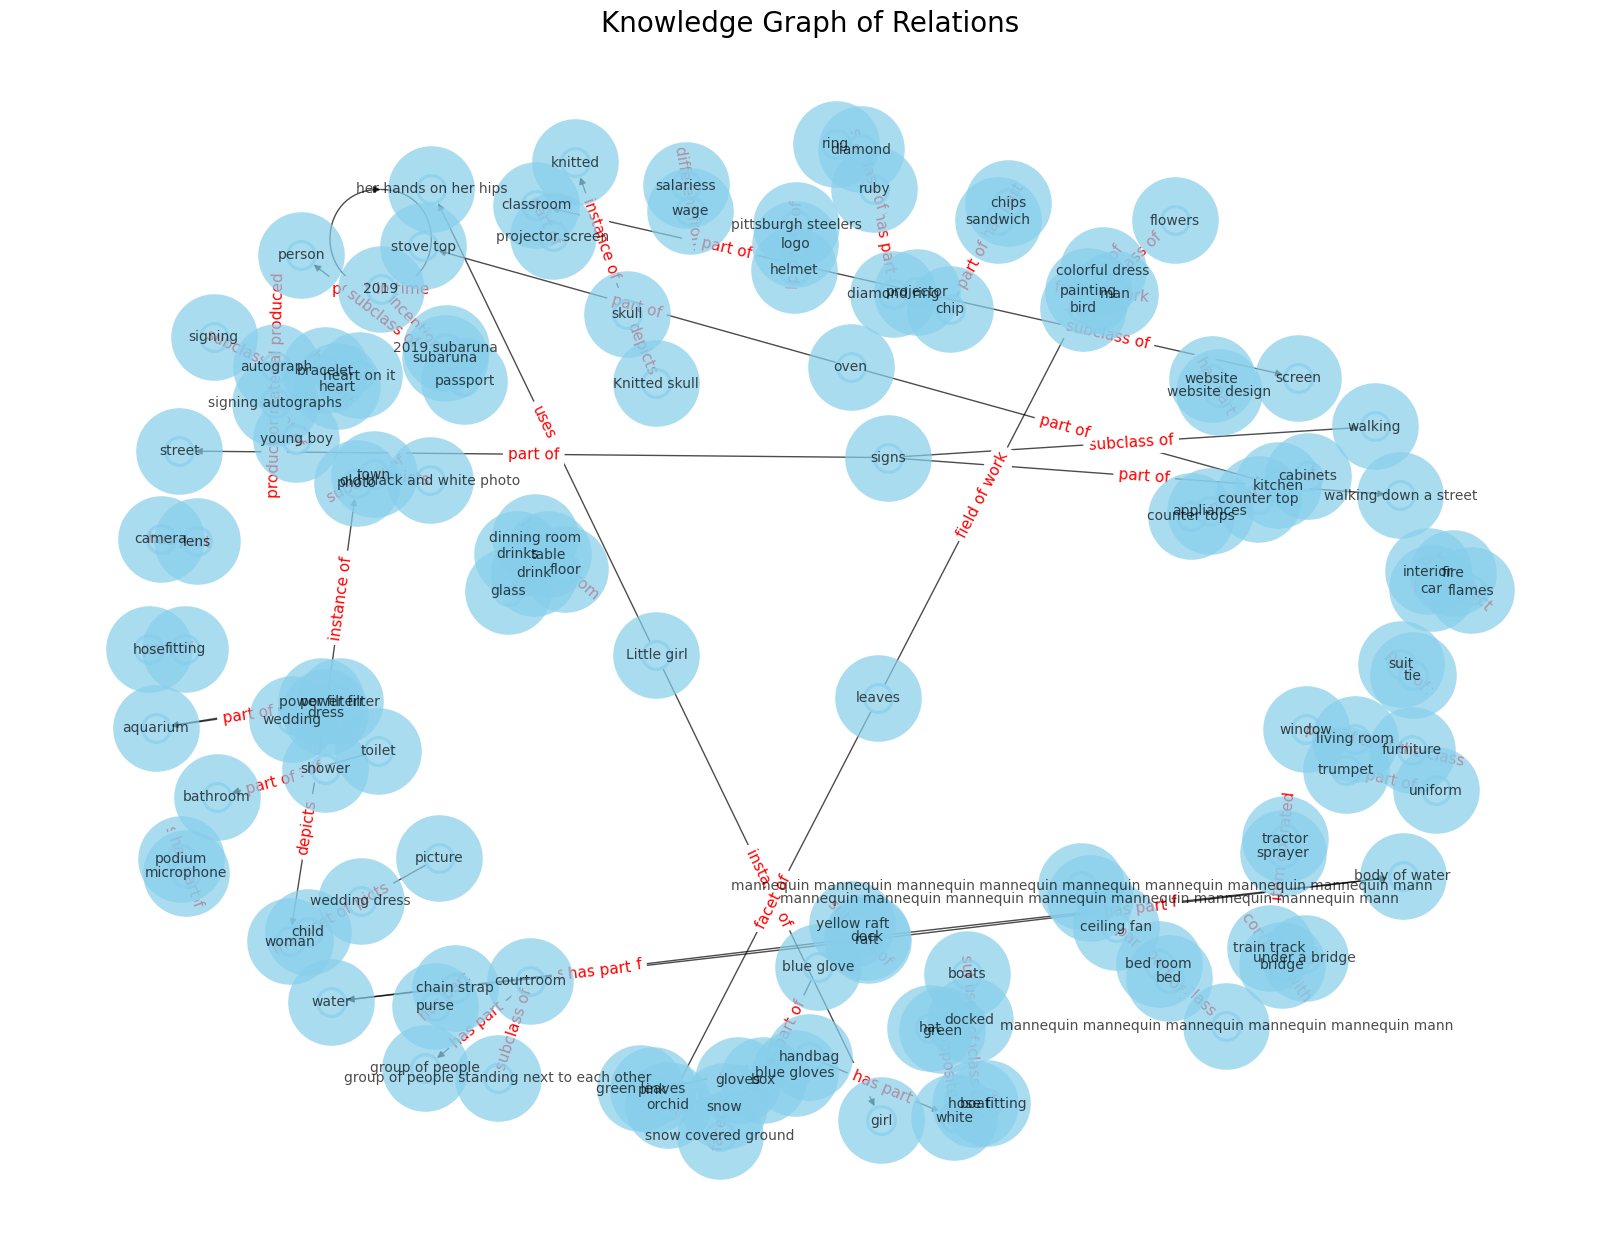

In [39]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load relations from CSV file
df = pd.read_csv('/kaggle/working/kge_text_51-100.csv')

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges from DataFrame
for _, row in df.iterrows():
    head = row['head']
    tail = row['tail']
    relation_type = row['type']
    G.add_edge(head, tail, relation=relation_type)

# Plot the graph
plt.figure(figsize=(16, 12))  # Increase figure size
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, node_shape='o', alpha=0.7, linewidths=40, font_size=10)  # Increase font_size
edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=11)  # Increase font_size
plt.title('Knowledge Graph of Relations', fontsize=20)  # Increase title font size
plt.show()
